# Project Group 16

Members: Jurian Fijen, Quirine Japikse, Christos Paschalidis, Kristian Terlien, Timo Locher

Student numbers: 

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*

Research question: What is the effect of the population density of the surroundings of a station on the first and last mile transport of their NS stations?

The plan is to combine first- and last-mile transport data from NS with CBS data concerning the built environment of the train station surroundings. Cumbersome first- and last-mile transport can be an inhibition in choosing public transport. The goal is to obtain a better understanding of these factors in multi-modal trips. Data sources are NS, CBS, PDOK en Overheid.nl. Data from the year 2019 is used and only within the NS stations form the provinces North- and South-Holland.



# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**: Jurian Fijen

**Author 2**: Quirine Japikse

**Author 3**: Christos Paschalidis

**Author 4**: Kristian Terlien

**Author 5**: Timo Locher

# Data Used

Data sources: \
NS station data: https://dashboards.nsjaarverslag.nl/reizigersgedrag/ \
CBS data (population): https://opendata.cbs.nl/statline/#/CBS/nl/ \
PDOK (area): https://service.pdok.nl/cbs/postcode4/atom/postcode4_numeriek_deel.xml

# Data Pipeline

The NS data provides insight into the pre- and post-transportation from the stations. Moreover, we combine the surface area and the number of inhabitants of the postal codes to calculate the population density. Subsequently, an assumption has been made about which postal codes use which stations. The average population density associated with a station and the pre- and post-transportation can provide insight into the choices regarding the types of modes of transport. Postal codes were chosen since they give a good insight to the characteristics of the surroundings of a train station. The actual postal code were the station is located is called zone0 and the surrounding postal codes including zone0, are called zone1.


NS data: We begin by reading-in all the data regarding North and South Holland stations off the NS website (one station/year at a time) and parse through the information. The entries are merged and create a single csv.\
Data 2: For the second dataset, the population density per postal code was examined. Using the number of inhabitants of the postal codes from the CBS combined with the surface areas of the postal codes calculated by QGIS using the geopackage from PDOK, this gives us the population density of all the necessary postal codes. This has been processed into a CSV file.\
Data 3: The third dataset is intended to determine the locations of the NS stations. This information comes from Overheid.nl. This too has been converted into a CSV file. Using the python script postcode_stations.py from the repository, QGIS was used to look up the postal code a station was in, called zone0. Then, all surrounding postal codes were combined with the original postal code to form zone1. The respective postal codes are included in this csv file

# Load Libraries

In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set() # set seaborn as default plot style

# Data Import / Filtering

### NS Data 

#### Import and filtering of NS data is done in notebook Read_ns_data.ipynb 
https://github.com/Christos02/TIL16/blob/main/Read_ns_data.ipynb

In [14]:
df_ns = pd.read_csv('df_ns_Holland.csv')

In [15]:
# extract data for a specific station on a specific year
df_ns[(df_ns['Station'] == 'alphen-aan-den-rijn') & (df_ns['Year'] == 2019)]

,Station,Year,Reizigers per dag,Klantoordeel,In- en uitstappers,Overstappers,Ochtendspits,Avondspits,Daluren,Lopend_voor,...,Fiets_voor,Fiets_na,Bus/tram/metro_voor,Bus/tram/metro_na,Auto (bestuurder)_voor,Auto (bestuurder)_na,Auto (passagier)_voor,Auto (passagier)_na,(Deel)taxi_voor,(Deel)taxi_na
0,alphen-aan-den-rijn,2019,12630,72%,10996,1634,32%,13%,55%,23%,...,48%,24%,17%,17%,8%,2%,4%,11%,0%,0%


In [16]:
# extract data for a specific year
df_ns[df_ns['Year'] == 2019].head()

,Station,Year,Reizigers per dag,Klantoordeel,In- en uitstappers,Overstappers,Ochtendspits,Avondspits,Daluren,Lopend_voor,...,Fiets_voor,Fiets_na,Bus/tram/metro_voor,Bus/tram/metro_na,Auto (bestuurder)_voor,Auto (bestuurder)_na,Auto (passagier)_voor,Auto (passagier)_na,(Deel)taxi_voor,(Deel)taxi_na
0,alphen-aan-den-rijn,2019,12630,72%,10996,1634,32%,13%,55%,23%,...,48%,24%,17%,17%,8%,2%,4%,11%,0%,0%
4,barendrecht,2019,6066,79%,6066,0,33%,12%,55%,21%,...,34%,22%,4%,8%,28%,6%,13%,24%,0%,0%
8,bodegraven,2019,3448,68%,3448,0,37%,10%,53%,36%,...,42%,25%,1%,2%,16%,4%,5%,18%,0%,0%
12,boskoop,2019,1432,78%,1432,0,33%,9%,58%,29%,...,58%,27%,0%,7%,6%,3%,6%,9%,1%,0%
16,boskoop-snijdelwijk,2019,667,92%,667,0,35%,7%,58%,0%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


### Population density calculation ###
To obtain an estimation of the population density around a train station, the population density for the postal codes in and around the stations is calculated. The surface area was calculated using QGIS and the number of inhabitants is retrieved from CBS data.

In [17]:
#necessary datasets


postcodes = pd.read_csv('postal_codes_data_final.csv')
postcode_array = postcodes['postcode'].to_numpy()

#create an array for the area in the right unit
area_m2 = postcodes['oppervlakte'].to_numpy()
area_km2 = area_m2 *10e-06

#create an array for the number of inhabitants and calculate population density
inhabitants = postcodes['aantal_inwoners'].to_numpy()
pop_density = inhabitants / area_km2

postcode_density = pd.DataFrame(np.c_[postcode_array, pop_density])

#create postcode population density dictionary
pp_dict = dict(zip(postcode_array,pop_density))

### Combining stations with postal codes ###
Combining the data file containing the postal codes for zone0 and zone1, and the file containing the population density for each postal code, the population density for both zone0 and zone1 are calculated. For zone1, the average population density for all postal codes is calculated. All these results are then saved to a .csv file containing the station, postal codes for zone0 and zone1 and the population density for zone0 and zone1. 

In [18]:
stations = pd.read_csv('NS_stations_met_aangrenzende_postcodes.csv', delimiter = ',')
stations

#add the population density data for zone0
postcode_gebied_station_arr = stations['postcode_gebied_station'].to_numpy()

#create array with populetion density zone 0
pop_dens_zone0 = np.zeros(len(postcode_gebied_station_arr))
for i in range(len(postcode_gebied_station_arr)):
    pop_dens_zone0[i] = pp_dict[postcode_gebied_station_arr[i]]
    
#add to dataframe
stations['pop_density_zone0'] = pop_dens_zone0
stations


#calculate population density for zone1
zone1_arr = stations['postcode_aangrenzende_postcode_gebieden'].to_numpy()

#split strings into lists
for i in range(len(zone1_arr)):
    zone1_arr[i] = zone1_arr[i].split(',') 

#create array with population density for zone1
pop_dens_zone1 = np.zeros(len(zone1_arr))

#calculate average pop dens of postal codes
for j in range(len(zone1_arr)):
    sum_pop_dens = 0
    for i in range(len(zone1_arr[j])):    
        sum_pop_dens += pp_dict[int(zone1_arr[j][i])]
    avg_pop_dens = sum_pop_dens/len(zone1_arr[j])
    pop_dens_zone1[j] = avg_pop_dens

#add to dataframe
stations['pop_density_zone1'] = pop_dens_zone1
stations.to_csv('population_densities.csv')
stations

,station_naam,postcode_gebied_station,postcode_aangrenzende_postcode_gebieden,pop_density_zone0,pop_density_zone1
0,'t-harde,8084,"[8072, 8081, 8084, 8085, 8096, 8162]",28.675240,40.251723
1,helmond-'t-hout,5707,"[5673, 5674, 5701, 5702, 5706, 5707, 5708, 573...",140.713961,194.702712
2,abcoude,1391,"[1105, 1106, 1107, 1108, 1109, 1191, 1383, 139...",33.988684,131.058002
3,akkrum,8491,"[9001, 8467, 8468, 8491, 8493, 8494, 8495, 9011]",28.227843,12.540703
4,alkmaar,1815,"[1811, 1814, 1815, 1816, 1817, 1823, 1824, 1851]",424.124882,438.229208
...,...,...,...,...,...
245,zoetermeer-oost,2712,"[2719, 2665, 2711, 2712, 2713, 2718, 2722]",252.749370,383.649670
246,utrecht-zuilen,3551,"[3532, 3513, 3534, 3551, 3552, 3553]",1040.205826,932.222619
247,zutphen,7201,"[7201, 7202, 7203, 7204, 7205, 7206]",424.826342,247.983724
248,zwijndrecht,3331,"[3335, 3311, 3316, 3331, 3332, 3333, 3336, 334...",507.309600,312.804719


### Merging datasets ###
Lastly, the NS-data and postal code-data are combined into one dataframe. This procedure finalizes the data filtering.

In [19]:
df_ns_2019 = df_ns[df_ns['Year'] == 2019].copy()

#set index for both dataframes
df_ns_2019 = df_ns_2019.set_index('Station').copy()
df_ns_2019
stations = stations.set_index('station_naam').copy()

#merge both dataframes
stations_merged = stations.merge(df_ns_2019, left_index=True, right_index=True)
stations_merged


,postcode_gebied_station,postcode_aangrenzende_postcode_gebieden,pop_density_zone0,pop_density_zone1,Year,Reizigers per dag,Klantoordeel,In- en uitstappers,Overstappers,Ochtendspits,...,Fiets_voor,Fiets_na,Bus/tram/metro_voor,Bus/tram/metro_na,Auto (bestuurder)_voor,Auto (bestuurder)_na,Auto (passagier)_voor,Auto (passagier)_na,(Deel)taxi_voor,(Deel)taxi_na
alkmaar,1815,"[1811, 1814, 1815, 1816, 1817, 1823, 1824, 1851]",424.124882,438.229208,2019,22018,84%,21495,523,22%,...,45%,19%,21%,23%,3%,2%,6%,6%,0%,0%
alkmaar-noord,1824,"[1815, 1817, 1822, 1823, 1824, 1825, 1826]",662.224676,401.852825,2019,5046,52%,5046,0,35%,...,47%,25%,5%,10%,21%,5%,8%,15%,0%,1%
alphen-aan-den-rijn,2405,"[2401, 2404, 2405, 2406, 2407, 2408, 2409, 2771]",470.242977,198.061269,2019,12630,72%,10996,1634,32%,...,48%,24%,17%,17%,8%,2%,4%,11%,0%,0%
amsterdam-amstel,1097,"[1078, 1079, 1091, 1092, 1093, 1096, 1097, 109...",510.233026,837.942341,2019,37793,79%,36100,1693,14%,...,45%,13%,35%,50%,0%,0%,1%,1%,0%,0%
amsterdam-centraal,1012,"[1011, 1012, 1013, 1015, 1016, 1017, 1021, 1031]",725.358070,920.147031,2019,213035,87%,199510,13525,10%,...,29%,10%,49%,47%,0%,0%,1%,1%,0%,0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zaandijk-zaanse-schans,1541,"[1506, 1507, 1508, 1509, 1541, 1544, 1551]",352.832168,265.689155,2019,4535,58%,4535,0,22%,...,32%,7%,1%,0%,9%,1%,2%,15%,0%,0%
zandvoort-aan-zee,2042,"[2041, 2042, 2051, 2114, 2116, 2204]",45.416759,42.235615,2019,5858,79%,5858,0,16%,...,19%,8%,4%,4%,1%,1%,3%,4%,0%,0%
zoetermeer,2719,"[2642, 2719, 2641, 2651, 2712, 2713, 2715, 271...",425.775004,364.633390,2019,4868,54%,4868,0,28%,...,34%,9%,18%,18%,14%,3%,8%,9%,0%,0%
zoetermeer-oost,2712,"[2719, 2665, 2711, 2712, 2713, 2718, 2722]",252.749370,383.649670,2019,2657,59%,2657,0,35%,...,32%,21%,8%,18%,21%,6%,7%,12%,0%,0%


# Data Analysis
### Postal codes visualization
To illustrate how the postal codes are structured, an example is shown containing the zone1 for station Delft and the population densities per postal codes. The green dot represents the train station. The image is made using the geopandas library.

In [20]:
#import geopackages
postcode_geopackage = gpd.read_file('cbs_pc4_2019.gpkg')
stations_geopackage = gpd.read_file('clipped_stations.gpkg')
postcode_geopackage = postcode_geopackage.set_index('postcode')
stations_geopackage = stations_geopackage.set_index('Lang')

In [21]:

postcode_geopackage['pop_density'] = pop_density

In [22]:
#add population densities
postcode_geopackage['pop_density'] = pop_density

#create geoseries
postcode_geometries = postcode_geopackage['geometry']
stations_geometries = stations_geopackage['geometry']

#create geometries
stations_geometries = stations_geometries.to_crs(postcode_geopackage.crs)
stations_geopackage = stations_geopackage.set_geometry(stations_geometries)

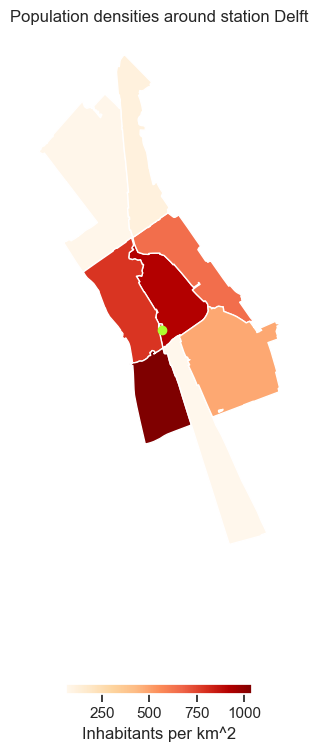

In [28]:
#geodataframes of station and surrounding postal codes
station_delft_locatie = stations_geopackage.loc[['Delft']]
postcode_delft = gpd.GeoDataFrame([postcode_geopackage.loc[2611], postcode_geopackage.loc[2612],
                                   postcode_geopackage.loc[2288], postcode_geopackage.loc[2289],
                                   postcode_geopackage.loc[2613], postcode_geopackage.loc[2624], 
                                   postcode_geopackage.loc[2627], postcode_geopackage.loc[2628]],
                                   geometry=postcode_geopackage['geometry'])

#plotting
f, ax = plt.subplots(1, figsize=(6,10))
plt.title('Population densities around station Delft')
postcode_delft.plot(column='pop_density', ax=ax, cmap='OrRd', legend=True, legend_kwds={'label': 'Inhabitants per km^2',
                                                                                        'shrink': 0.4, 
                                                                                       'orientation': 'horizontal'})
station_delft_locatie.plot(ax=ax, c='greenyellow')
ax.set_axis_off()
plt.show()

### Scatter Plots

In [29]:
stations_merged
modalities = stations_merged.loc[:, 'Lopend_voor':'Auto (passagier)_na'].columns
shapes = ['o','s'] * 5
colors = ['red','blue'] * 5

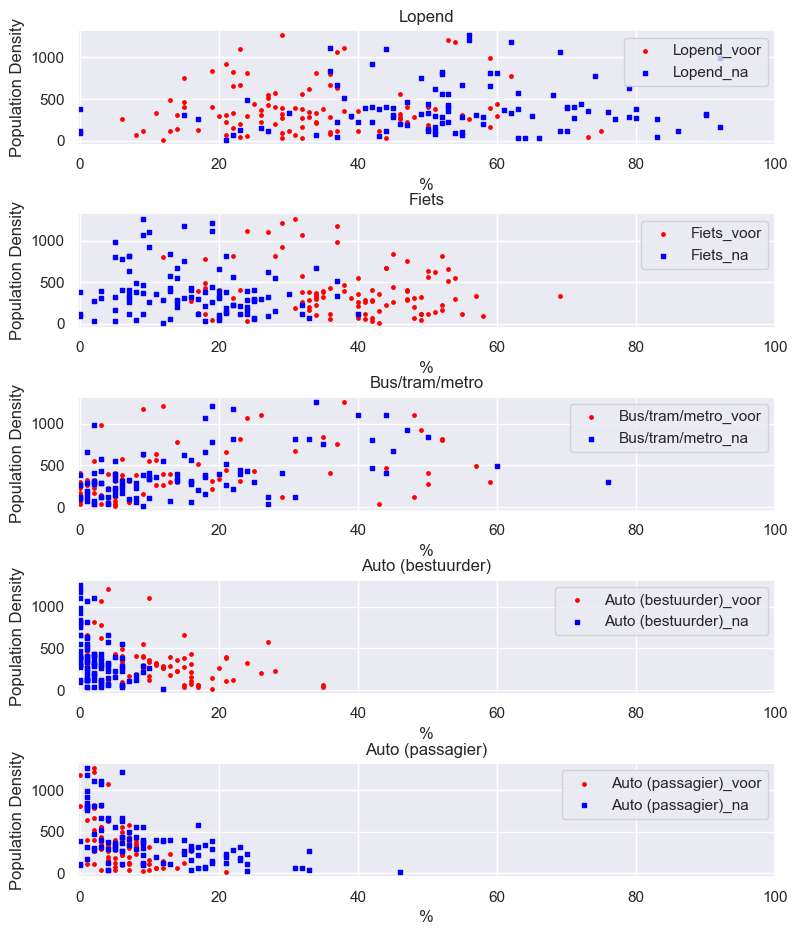

In [30]:
fig, axes = plt.subplots(5, 1, figsize=(9, 11))
for i,modality in enumerate(modalities):
    axes[int(i/2)].scatter(stations_merged[modality].str.rstrip('%').astype(int),stations_merged['pop_density_zone1'],marker=shapes[i],label=modality,color=colors[i],s=6)
    axes[int(i/2)].legend()
    axes[int(i/2)].set_xlabel('%')
    axes[int(i/2)].set_ylabel('Population Density')
    axes[int(i/2)].set_title(modality.split('_')[0])
    axes[int(i/2)].set_xlim([-.3,100])
plt.subplots_adjust(hspace=0.6)
plt.show()

### Scatter Insight

* Walking: There is no differentiation in the percentage of people walking to/from the station in regards to the population density. However it is observed that more people walk from the station rather to the station. 
* Cycling: Cycling to and from a station is observed less on stations with high population densities. Also, at a station with a bicycle is more popular than departing. 
* Other public transport: The use of other public transport is much more popular on high population density stations but this might be a result of the available options. Using other public transport is done about evenly for first and last mile transport.
* Car (driver): Driving a car to and from a station is by far more popular for lower population density stations. It is also mostly used as a first-mile transport
* Car (passenger): Again being driven in a car to and from a station is by far more popular for lower population density stations. However, it is mostly observed in last-mile transport